In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
signal_data = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet')

background_data_ttsemilep = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTToSemiLeptonic.parquet')
background_data_tthadronic = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTToHadronic.parquet')
background_data_ttdilep = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTTo2L2Nu.parquet')


background_data = pd.concat([background_data_ttsemilep, background_data_tthadronic, background_data_ttdilep])


In [4]:
signal_data = pd.read_hdf('/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5')
background_data = pd.read_hdf('/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5')

In [5]:
## DATA PREPARATION



def prep(signal_data, background_data):

    #remove NaN values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    #remove unsuitable regions in the regions column (want only 0 and 6+)
    regions_to_exclude = [1,2,3,4,5]
    signal_data = signal_data[~signal_data.region.isin(regions_to_exclude)]
    background_data = background_data[~background_data.region.isin(regions_to_exclude)]
    
    #add balance weights
    # this helps balance the training dataset. Signal data points are given HIGHER weights based on the imbalance
    #weight=1 is the base weight, which we assign to background_data
    # creating new column 'weight_balance' and assigning it to 1 for background_data and len(background_data)/len(signal_data) for signal_data
    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1
    #this weight is applied to the loss^ 

    # Label signal and background data
    signal_data['target'] = 1
    background_data['target'] = 0

    #combine sign & BG datasets
    data = pd.concat([signal_data, background_data])



    ###
    # Look into jets, otherwise just delete:

    #add additional columns to the data frame
    # calculating statistical properties of cleanedJet_eta and 
    #cleanedJet_phi, such as standard deviation (std) and range (max-min).
    #New features can be useful for model
    # data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    # data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    # data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    # data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))
    # ###
    return data

data = prep(signal_data, background_data)


In [6]:
# Define features and scale them
features = [
    'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt',
    'MinChi', 'MinOmegaHat', 'MinOmegaTilde','ldphi_bjet', 'ldphi_jet', 'ncleanedBJet',
    'ncleanedJet', 'sdphi_bjet', 'sdphi_jet'
]

#scales features to have a mean = 0  and std = 1 (makes training more stable & efficient).
scaler = StandardScaler()
#Fit the scalar to selected features in data & transform them in place, overwriting opriginal values witht he SCALED ones
data[features] = scaler.fit_transform(data[features])



#we need to scale as some features varyb widely in magnitude which can hinder training.
#NN's are sensitive to the scale of the input data. Scaling ensures all features contribute proportionally to the models training process.


In [7]:
len(features)

14

In [8]:
# Convert data to PyTorch tensors

#Convert features to tensors(x). X is a tensor containing values of selected features from data[features].values
X = torch.tensor(data[features].values, dtype=torch.float32)

# Convert target to tensors(y). y is a tensor of target labels, indicating whether sample is sig (1) or BG (0).as_integer_ratio
# #.view(-1,1) reshapes y into column vector for binary classification.
y = torch.tensor(data['target'].values, dtype=torch.float32).view(-1, 1)

#converting weights to tensors. Used later in training loop to handle class imbalance
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)


In [9]:
# Split data into train, validation, and test sets.
#80/20 train/test split. Outputs represent features labels, nominal weights & balance weights for both..
#.. training & validation set and test set.
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(
    X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42
)
#each x_train val is paired with y_train_val, wn_train_val, wb_train_val. (X_train_val, y_train_val, wn_train_val, wb_train_val)
#each x_test is paired with y_test, wn_test, wb_test. (X_test, y_test, wn_test, wb_test)
# ... allows us to keep track of weights. 

#this splits the training+validation set into   (64%) and validation (16%). These numbers come from 0.8*0.8=0.64, 0.8*0.2=0.16. 
#1st split is training+validation vs test. Second split only on the training+validation. 80% training, 20% validation.
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val = train_test_split(
    X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42
)


#Training set trains model. (Xtrain,yt_train,wn_train,wb_train)
#Validation set evaluates models performance during trainign & adjusts hyperparameters if needed. (X_val,y_val,wn_val,wb_val
#Test set is set aside until end of training to evaluate the model's generalisation ability on completely unseen data. (xtets,ytest,wntest,wbtest)


In [10]:
# Create DataLoaders

#(#Look at gradient descent mini batch)

#DataLoader is a PyTorch class that loads data in batches.
#train_loader loads training data in batches of 64 samples. shuffle=True shuffles the data before each epoch.
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)

#val_loader loads validation data in batches of 64 samples. shuffle=False as we don't want to shuffle validation data.
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)

#test_loader loads test data in batches of 64 samples. shuffle=False as we don't want to shuffle test data.
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

#shuffle is set to True for training data, as we want to shuffle the data before each epoch to prevent the model from learning the order of the data.

In [11]:
#Defining NN model & initialising loss function & optimiser

#nn.Module is a base class for all NN models in PyTorch. Represents a simple feedforward..
#.. NN with customisable layers & neurons, disigned for binary classification.

class SimpleNN(nn.Module):
    # n_layers is the no. of HIDDEN LAYERS and n_neurons is the no. of neurons in each HIDDEN layer.
    def __init__(self, n_layers=3, n_neurons=32):
        #super() is a method that returns a proxy object that delegates method calls to a parent or sibling class of type.
        #Here, super(SimpleNN, self).__init__() initialises the base class (nn.Module) for the SimpleNN class.
        super(SimpleNN, self).__init__()
        #layers ia a listy that temporatily holds each layer of the model as it is created.
        #this allows us to construct the NN architecture in a loop, rather than writing each layer out individually.
        layers = [nn.Linear(len(features), n_neurons), nn.BatchNorm1d(n_neurons)]
        
        #for loop that creates n_layers-1 hidden layers, each with n_neurons neurons.
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons)]
        #adds the output layer to the model. This is a single neuron, as we are performing binary classification.
        layers.append(nn.Linear(n_neurons, 1))
        #nn.ModuleList(layers) converts the list of layers into a PyTorch ModuleList, which is a container for Module objects.
        self.layers = nn.ModuleList(layers)

    #the forward method defines the forward pass of the NN. It takes an input tensor x and passes it through each layer of the model.
    def forward(self, x):
        for layer in self.layers[:-1]:
            #applies the ReLU activation function to the output of each hidden layer to introduce non-linearity.
            x = torch.relu(layer(x))
        
        #return self.layers[-1](x) applies the output layer to the final hidden layer output, returning the final model output.
        return self.layers[-1](x)
        #x is not a value between 0 and 1, but a value between -inf and inf. This is because the output layer is a single neuron with no activation function.
        #x is a logit
model = SimpleNN()



In [12]:
# Define loss function and optimizer

#criterion is the loss function used to train the model. Here, we use Binary Cross-Entropy Loss with logits.
#optimiser is the optimisation algorithm used to update the model weights during training. Here, we use the Adam optimiser.

criterion = nn.BCEWithLogitsLoss(reduction="none")  # With weight balancing
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#lr is the learning rate of the optimiser. This is a hyperparameter that controls the step size of the optimiser during training.

In [13]:
# An epoch is a single pass through the entire training dataset.
n_epochs = 40
#train_losses and val_losses are lists that store the training and validation losses for each epoch.
train_losses, val_losses = [], []

# Training phase
for epoch in range(n_epochs):
    #model.train() sets the model to training model, which enables features like dropout and batch normalisation.
    model.train()

    #running_train_loss and running_val_loss are variables that store the cumulative loss for each epoch.
    running_train_loss = 0.0

    #train_loader is an iterable object that returns batches of training data.
    for batch_x, batch_y, _, batch_wb in train_loader:
        #Zero the gradients to prevent them from accumulating.
        optimizer.zero_grad()
        #model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        #calulates the loss between the model outputs and the target labels.
        loss = criterion(outputs, batch_y.view(-1, 1))

        # Multiplies the loss by the balancing wwight (1 for BG and ~6 for sig) to handle class imbalance.
        weighted_loss = (loss * batch_wb).mean()
        #Backpropagates the loss through the model to calculate the gradients.
        weighted_loss.backward()
        #Updates the model weights using the gradients and the optimiser.

        #goes back and adjusts the weights of the model to reduce the loss. MAYBE
        optimizer.step()
        #running_train_loss accumulates the weighted loss for each batch.
        running_train_loss += weighted_loss.item() * batch_x.size(0)

    #train_losses appends the average training loss for the epoch.
    train_losses.append(running_train_loss / len(train_loader.dataset))





    # Validation phase (model doesn't see this)
    
    #model.eval() sets the model to evaluation mode, which disables features like dropout and batch normalisation.
    model.eval()
    #running_val_loss is a variable that stores the cumulative validation loss for each epoch.
    running_val_loss = 0.0
    #torch.no-grad disables gradient calculation, which reduces memory usage and speeds up computation.
    with torch.no_grad():
        #val_loader is an iterable object that returns batches of validation data.
        for batch_x, batch_y, _, batch_wb in val_loader:
            #calculates the validation loss for the model.
            val_loss = criterion(model(batch_x), batch_y.view(-1, 1))
            #Help handle class imbalance.
            weighted_val_loss = (val_loss * batch_wb).mean()
            # accumulates the weighted validation loss for each batch.
            running_val_loss += weighted_val_loss.item() * batch_x.size(0)
    #val_losses appends the average validation loss for the epoch.
    val_losses.append(running_val_loss / len(val_loader.dataset))

#Prints the training and validation losses for each epoch.
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')


Epoch [1/40], Training Loss: 0.8102, Validation Loss: 0.7434
Epoch [2/40], Training Loss: 0.7398, Validation Loss: 0.7284
Epoch [3/40], Training Loss: 0.7307, Validation Loss: 0.7228
Epoch [4/40], Training Loss: 0.7255, Validation Loss: 0.7202
Epoch [5/40], Training Loss: 0.7225, Validation Loss: 0.7169
Epoch [6/40], Training Loss: 0.7195, Validation Loss: 0.7152
Epoch [7/40], Training Loss: 0.7170, Validation Loss: 0.7133
Epoch [8/40], Training Loss: 0.7151, Validation Loss: 0.7117
Epoch [9/40], Training Loss: 0.7134, Validation Loss: 0.7117
Epoch [10/40], Training Loss: 0.7121, Validation Loss: 0.7099
Epoch [11/40], Training Loss: 0.7117, Validation Loss: 0.7083
Epoch [12/40], Training Loss: 0.7096, Validation Loss: 0.7072
Epoch [13/40], Training Loss: 0.7091, Validation Loss: 0.7067
Epoch [14/40], Training Loss: 0.7080, Validation Loss: 0.7067
Epoch [15/40], Training Loss: 0.7071, Validation Loss: 0.7062
Epoch [16/40], Training Loss: 0.7072, Validation Loss: 0.7045
Epoch [17/40], Tr

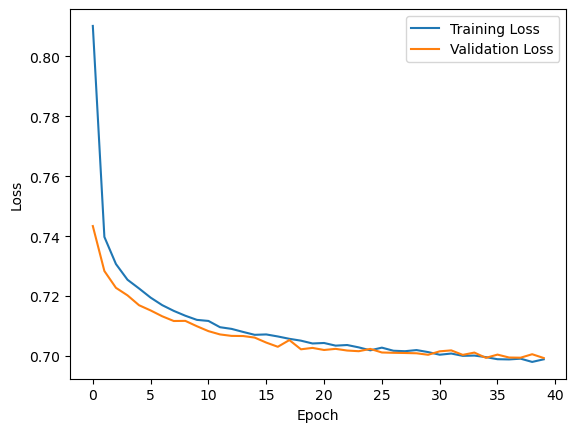

In [14]:
# Plot training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


    

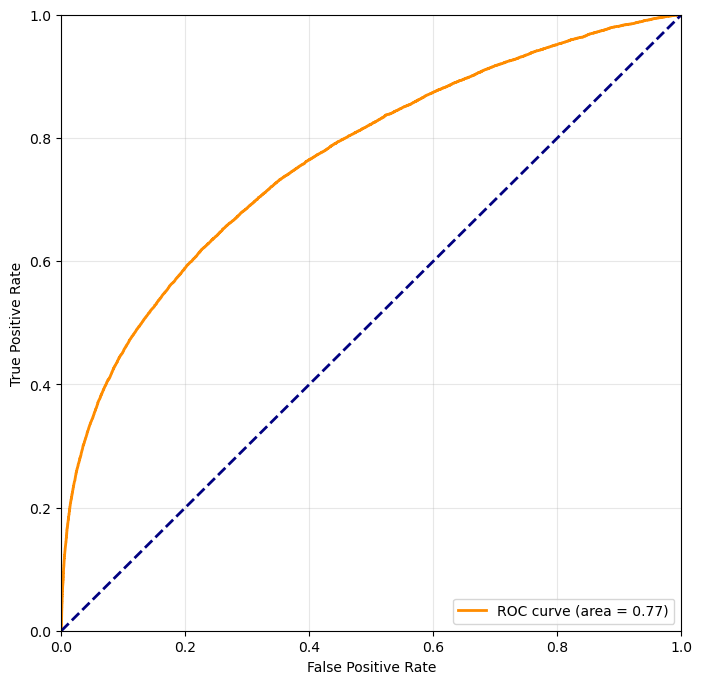

In [15]:
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
model.eval()
y_test_pred = []
with torch.no_grad():
    for batch_x, _, _, _ in test_loader:
        outputs = model(batch_x)
        y_test_pred.append(outputs)

# Concatenate all predictions
y_test_pred = torch.cat(y_test_pred).cpu().numpy()
y_test_true = y_test.cpu().numpy()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
plt.grid(alpha=0.3)

plt.legend(loc="lower right")
plt.show()

In [16]:
# np.savez('roc_data_MLPbinary.npz', 
#          fpr=fpr, 
#          tpr=tpr, 
#          auc=roc_auc)


### Plot Histograms For Model Output

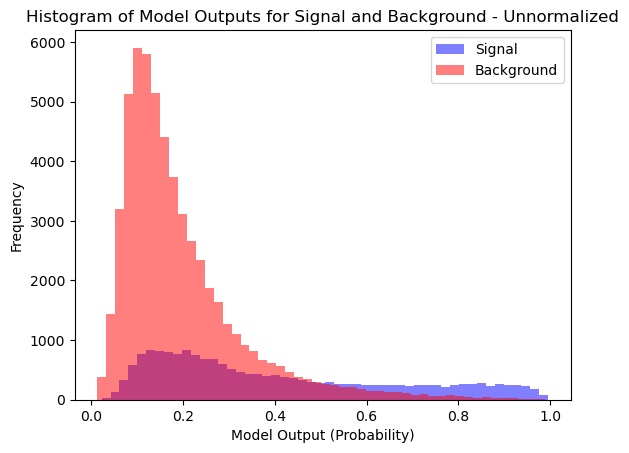

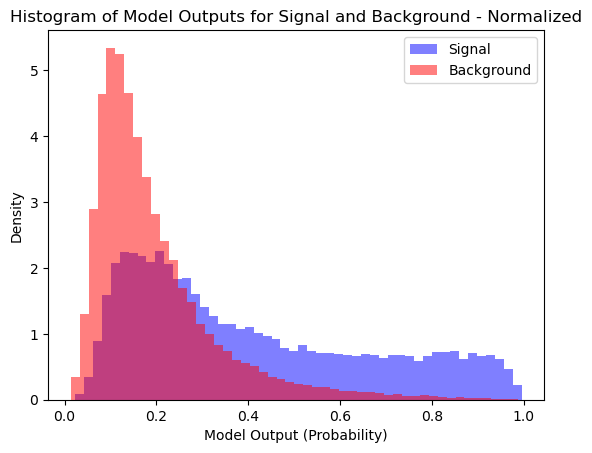

In [17]:
# Apply sigmoid function to model outputs to get probabilities
signal_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 1])).numpy()
background_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 0])).numpy()

# Plot histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red')
plt.xlabel('Model Output (Probability)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Unnormalized')
plt.show()

# Plot normalized histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red', density=True)
plt.xlabel('Model Output (Probability)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Normalized')
plt.show()

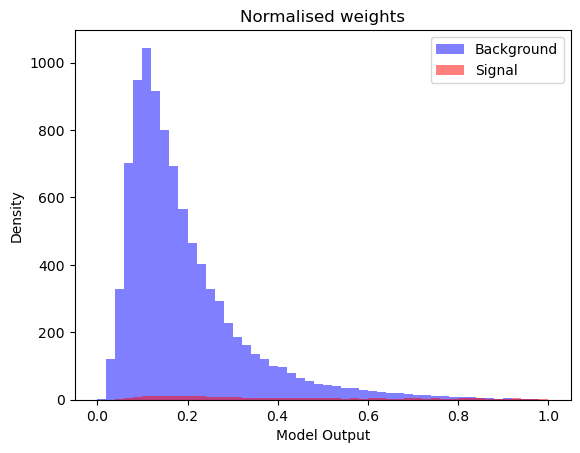

In [18]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.5, 
         label='Background', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',)

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5)


#plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



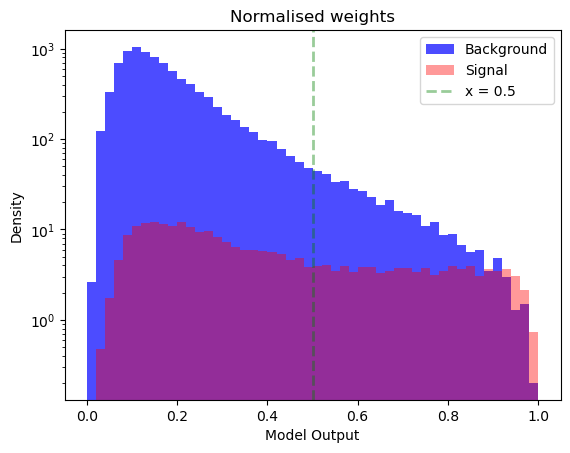

In [19]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r', alpha=0.4)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5',alpha=0.4)
plt.xlabel('Model Output')
plt.yscale('log')

plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



Instead of Z = S/sqrt(B),

Z = s/sqrt(B + sigma_b^2)  
where B is the background, S is the signal, and sigma_b is the uncertainty in the background.

Curve may peak in different place and curve will generally go down.

Maximum Z-score: 5.3088
Associated S value: 39.1373
Associated B value: 54.3452


In [20]:
# sigma_values = [0, 0.1]

# # Assume wn_test is the array of weights for each sample in the test set 
# wn_test_array = np.array(wn_test * 200000)

# # Define thresholds between 0 and 1
# thresholds = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(figsize=(10, 10))

# for sigma in sigma_values:
#     z_scores = []
#     s_values = []
#     b_values = []
#     for threshold in thresholds:
#         S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
#         B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background
#         s_values.append(S)
#         b_values.append(B)
        
#         # Checking both S and B are above a minimum value
#         Z = S / np.sqrt(B + (sigma * B) ** 2 + 1e-10) if (S >= 10 and B >= 10) else 0
#         z_scores.append(Z)
    
#     ax.plot(thresholds, z_scores, label=f"{int(sigma*100)}% systematic uncertainty")
    
#     # Find max Z score and corresponding threshold, S, B values
#     max_Z = max(z_scores)
#     max_index = z_scores.index(max_Z)
#     best_threshold = thresholds[max_index]
#     best_S = s_values[max_index]
#     best_B = b_values[max_index]
    
#     print(f"\nSigma = {sigma}")
#     print(f"Maximum Z score: {max_Z:.4f} at threshold = {best_threshold:.4f}")
#     print(f"S = {best_S:.4f}, B = {best_B:.4f}")

# ax.set_aspect('equal')

# ax.set_xlabel("Threshold")
# ax.set_ylabel("Z-score")
# #ax.set_title("Z-score vs. Threshold for Different Sigma Values")
# ax.legend()

# plt.tight_layout()
# plt.grid(alpha=0.3)
# plt.show()


Sigma = 0
Maximum Z score: 4.9550 at threshold = 0.8200
S = 27.4470, B = 30.6828

Sigma = 0.1
Maximum Z score: 4.3459 at threshold = 0.8900
S = 14.9993, B = 10.7554


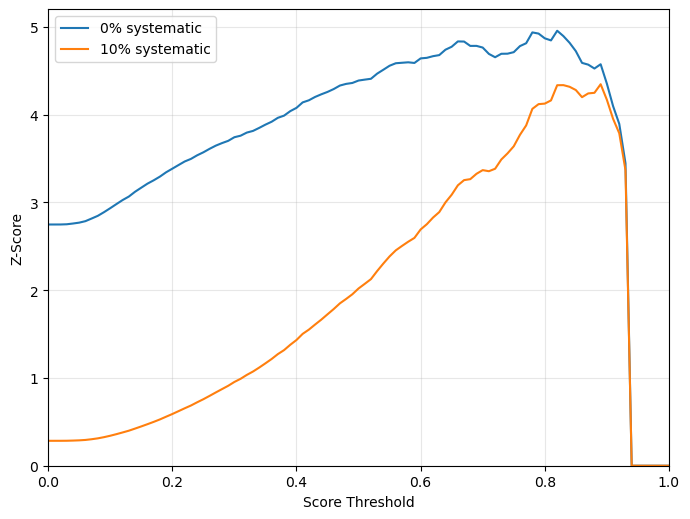

In [45]:
sigma_values = [0, 0.1]
wn_test_array = np.array(wn_test * 200000)
thresholds = np.linspace(0, 1, 101)  # Changed to 101 points

plt.figure(figsize=(7, 5.3))

for sigma in sigma_values:
    z_scores = []
    s_values = []
    b_values = []
    for threshold in thresholds:
        S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])
        B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])
        s_values.append(S)
        b_values.append(B)
        
        Z = S / np.sqrt(B + (sigma * B) ** 2 + 1e-10) if (S >= 3 and B >= 3) else 0
        z_scores.append(Z)
    
    plt.plot(thresholds, z_scores, label=f"{int(sigma*100)}% systematic")
    
    max_Z = max(z_scores)
    max_index = z_scores.index(max_Z)
    best_threshold = thresholds[max_index]
    best_S = s_values[max_index]
    best_B = b_values[max_index]
    
    print(f"\nSigma = {sigma}")
    print(f"Maximum Z score: {max_Z:.4f} at threshold = {best_threshold:.4f}")
    print(f"S = {best_S:.4f}, B = {best_B:.4f}")

# Set the axis limits explicitly to match scaling
plt.xlim(0, 1)
ymax = max(max(z_scores) for sigma in sigma_values)
plt.ylim(bottom=0)  # Add this line to set the lower y-axis limit to 0

plt.xlabel("Score Threshold")
plt.ylabel("Z-Score")
#plt.title('Z-Score vs Threshold')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Sigma = 0
Maximum Z score: 4.9550 at threshold = 0.8200
S = 27.4470, B = 30.6828

Sigma = 0.1
Maximum Z score: 4.3459 at threshold = 0.8900
S = 14.9993, B = 10.7554


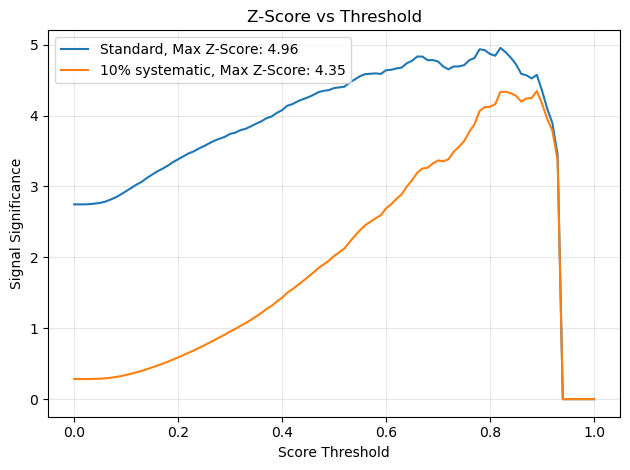

In [33]:
sigma_values = [0, 0.1]
wn_test_array = np.array(wn_test * 200000)
thresholds = np.linspace(0, 1, 101)  # Changed to 101 points to match other plot

#plt.figure(figsize=(6, 6))

for sigma in sigma_values:
    z_scores = []
    s_values = []
    b_values = []
    for threshold in thresholds:
        S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])
        B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])
        s_values.append(S)
        b_values.append(B)
        
        Z = S / np.sqrt(B + (sigma * B) ** 2 + 1e-10) if (S >= 4 and B >= 4) else 0
        z_scores.append(Z)
    
    # Modified label format to match other plot
    label = 'Standard' if sigma == 0 else f'{int(sigma*100)}% systematic'
    max_Z = max(z_scores)
    plt.plot(thresholds, z_scores, label=f'{label}, Max Z-Score: {max_Z:.2f}')
    
    max_index = z_scores.index(max_Z)
    best_threshold = thresholds[max_index]
    best_S = s_values[max_index]
    best_B = b_values[max_index]
    
    print(f"\nSigma = {sigma}")
    print(f"Maximum Z score: {max_Z:.4f} at threshold = {best_threshold:.4f}")
    print(f"S = {best_S:.4f}, B = {best_B:.4f}")

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

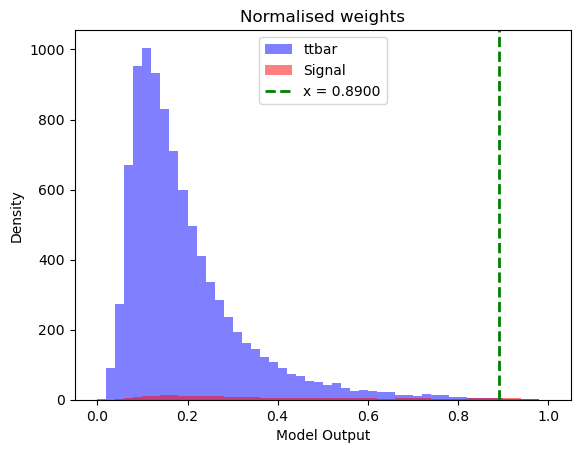

In [22]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.5, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',)

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5)


plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()

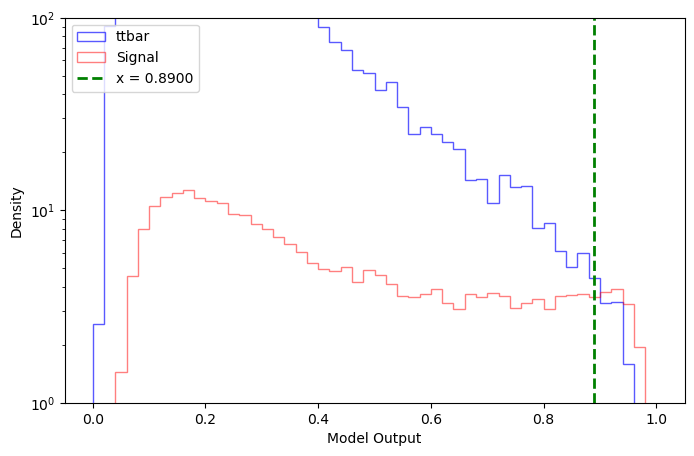

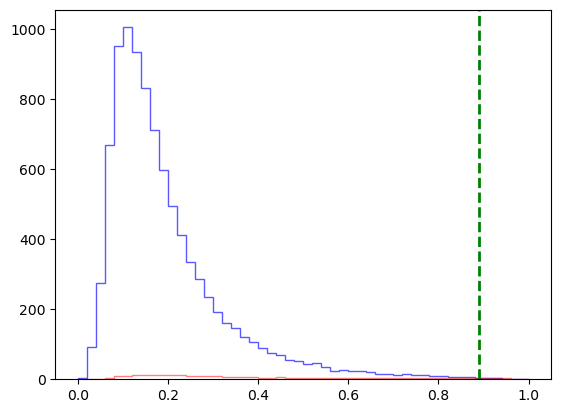

In [23]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.figure(figsize = (8,5))
plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.65, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',
         log=True,
         histtype='step')

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5,
         log=True,
         histtype='step')
plt.ylim(1,100)


plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.xlabel('Model Output')
plt.ylabel('Density')

#plt.title("Normalised weights")
plt.legend(loc='upper left')
plt.show()


plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.65, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',
         log=False,
         histtype='step')
plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5,
         log=False,
         histtype='step')

#plt.ylim(0.01,50)
plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.show()

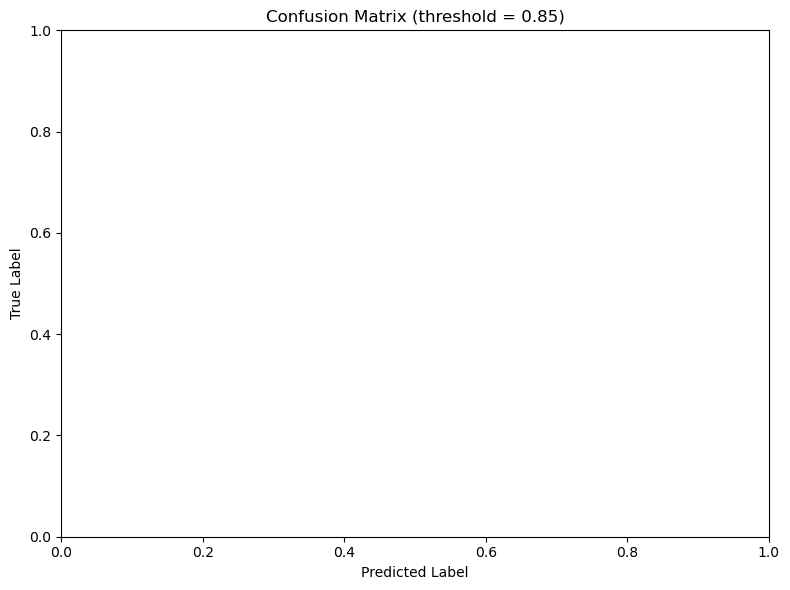

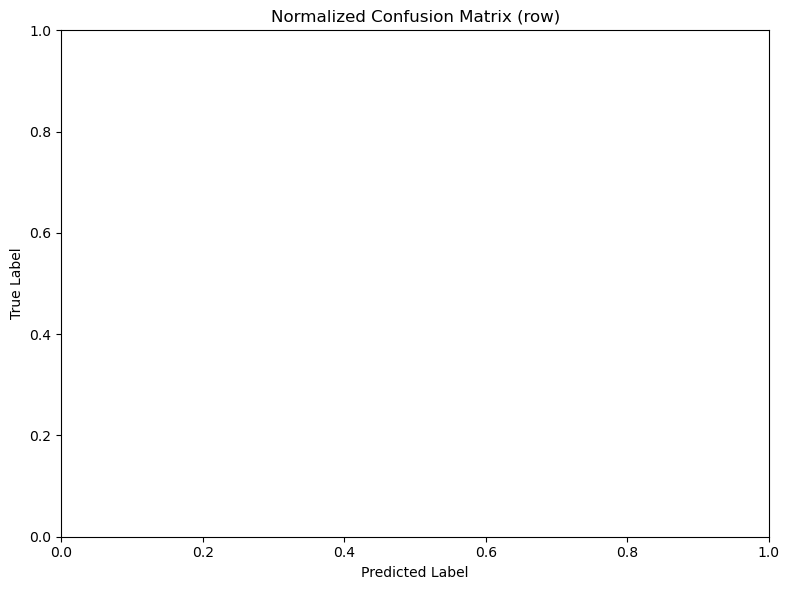

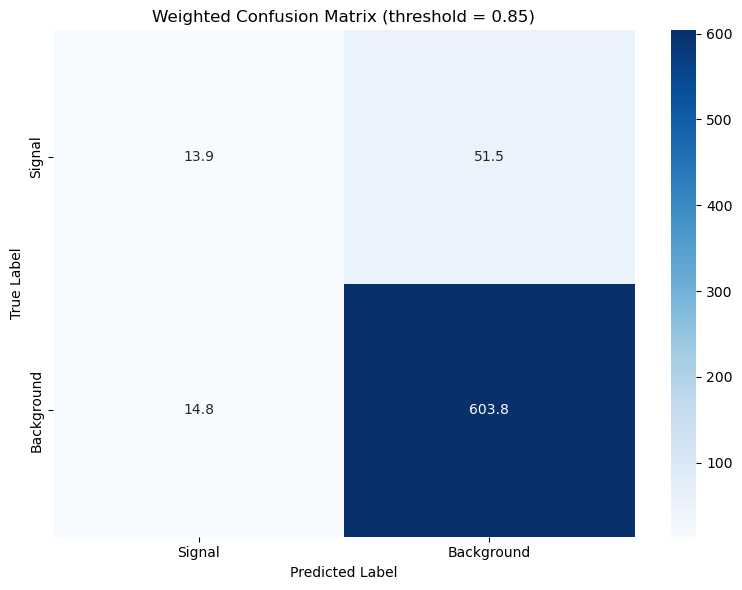

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Convert the output probabilities to binary predictions using the optimal threshold
y_pred_binary = (np.array(all_outputs) > best_threshold).astype(int)
y_true = all_labels

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Reorder the matrix to put Signal first, Background second
conf_matrix = conf_matrix[[1,0],:][:,[1,0]]  # Swap rows and columns

# Calculate performance metrics (using the original matrix)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Plot 1: Standard confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Signal', 'Background'],  # Swapped order
#             yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (threshold = {:.2f})'.format(best_threshold))
plt.tight_layout()
plt.show()

# Plot 2: Normalized confusion matrix
plt.figure(figsize=(8, 6))
# Normalize the reordered matrix
conf_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# sns.heatmap(conf_norm, annot=True, fmt='.2f', cmap='Blues',
#             xticklabels=['Signal', 'Background'],  # Swapped order
#             yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (row)')
plt.tight_layout()
plt.show()

# Plot 3: Weighted confusion matrix
plt.figure(figsize=(8, 6))
weighted_conf_matrix = np.zeros((2, 2))
wn_test_array = np.array(wn_test) * 200000

# Calculate weighted matrix with swapped indices
for i in range(2):
    for j in range(2):
        # Use (1-i) and (1-j) to swap 0->1 and 1->0
        mask = (y_true == (1-i)) & (y_pred_binary == (1-j))
        weighted_conf_matrix[i, j] = np.sum(wn_test_array[mask])

sns.heatmap(weighted_conf_matrix, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Signal', 'Background'],  # Swapped order
            yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Confusion Matrix (threshold = {:.2f})'.format(best_threshold))
plt.tight_layout()
plt.show()

#### Pretty Confusion Matrix For Report:

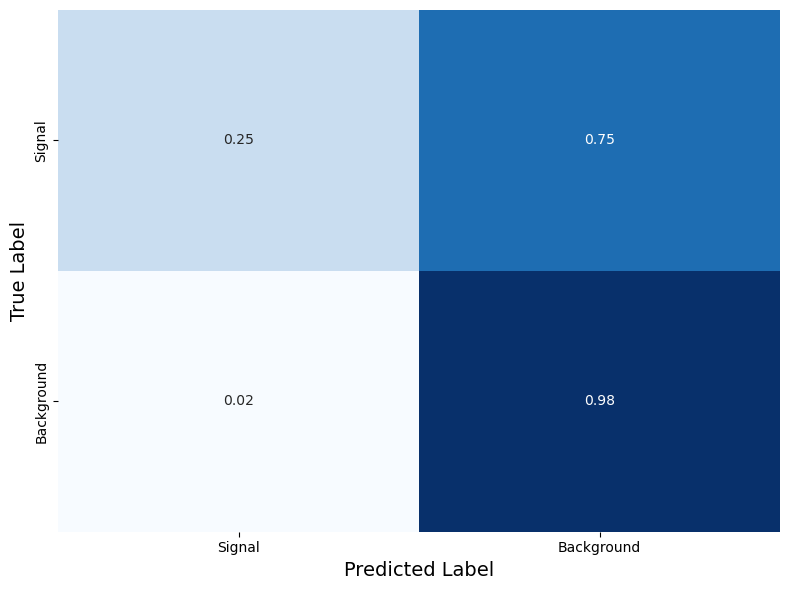

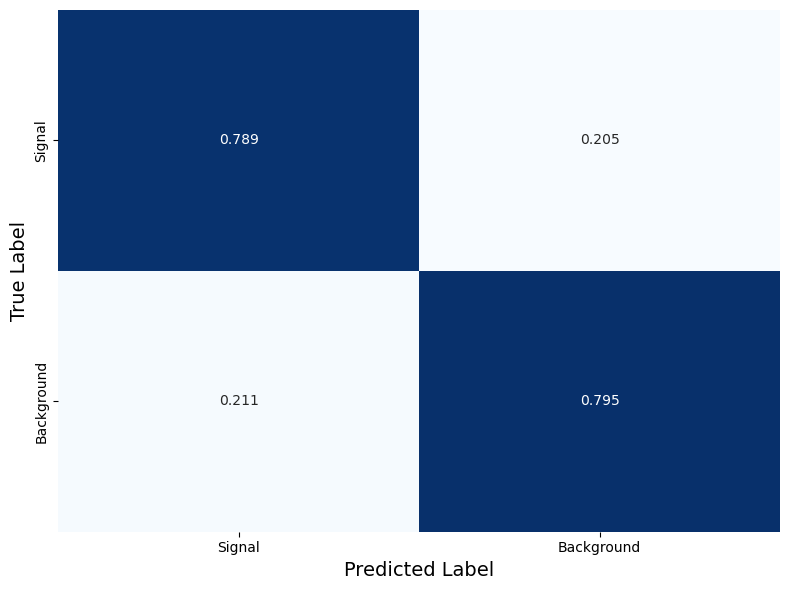

Metrics (threshold = 0.60):
Accuracy: 0.7947
Precision: 0.7888
Recall (Sensitivity): 0.2479
F1 Score: 0.3772
Specificity: 0.9778


In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Use the best threshold
best_threshold = 0.6

# Convert the output probabilities to binary predictions
y_pred_binary = (np.array(all_outputs) > best_threshold).astype(int)
y_true = all_labels

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Reorder the matrix to put Signal first, Background second
conf_matrix = conf_matrix[[1,0],:][:,[1,0]]  # Swap rows and columns

# Calculate performance metrics (using the original matrix)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Plot 1: Normalized by row (shows classification rate)
plt.figure(figsize=(8, 6))
conf_norm_row = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_norm_row, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'],cbar=False)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Normalized by column (shows precision)
plt.figure(figsize=(8, 6))
conf_norm_col = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[np.newaxis, :]
sns.heatmap(conf_norm_col, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'], cbar=False)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Print metrics
print(f"Metrics (threshold = {best_threshold:.2f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

In [ ]:
#  SHAP

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


X_background shape: (10000, 14)
X_explain shape: (10000, 14)
Number of features: 14


  0%|          | 0/10000 [00:00<?, ?it/s]

/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.481e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.185e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1

Type of shap_values: <class 'numpy.ndarray'>
SHAP values shape before squeeze: (10000, 14, 1)
SHAP values shape after squeeze: (10000, 14)
Mean abs SHAP values shape: (14,)
Flattened mean abs SHAP values shape: (14,)


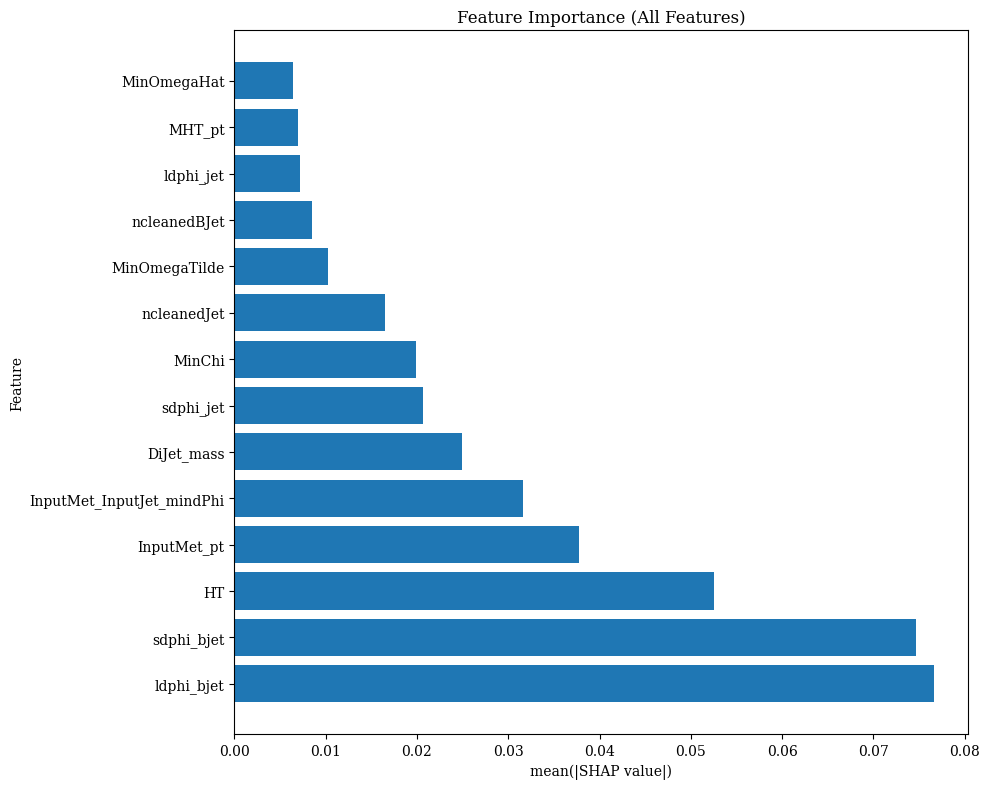

/tmp/ipykernel_3930827/1233214583.py:98: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


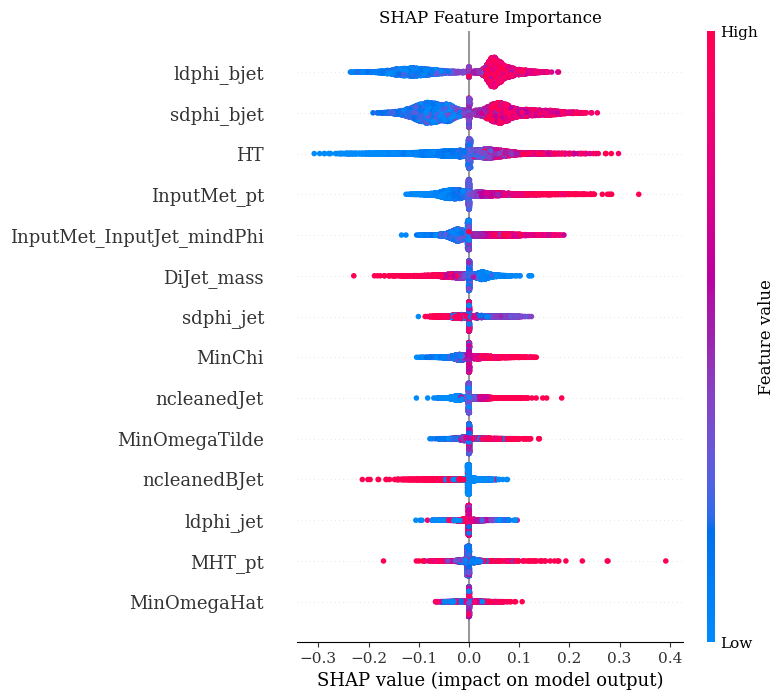

In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure everything runs on CPU to avoid device mismatch errors
model = model.cpu()

# Create a simple wrapper function to make predictions
def model_wrapper(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        output = model(x_tensor)
        return torch.sigmoid(output).numpy()

# Use a subset of your test data for SHAP analysis
n_samples = 10000  # Reduced sam.ple size for faster computation
X_background = X_test[:10000].cpu().numpy()  # Background dataset
X_explain = X_test[:n_samples].cpu().numpy()  # Samples to explain

# Check the shapes
print(f"X_background shape: {X_background.shape}")
print(f"X_explain shape: {X_explain.shape}")

# Make sure we have feature names
if 'features' not in globals() or not isinstance(features, list):
    print("WARNING: Features list missing or incorrect type, creating generic names")
    features = [f"Feature_{i}" for i in range(X_explain.shape[1])]
print(f"Number of features: {len(features)}")

# Initialize the SHAP explainer with fewer samples for speed
explainer = shap.KernelExplainer(model_wrapper, X_background, nsamples=50)

# Calculate SHAP values with explicit error handling
try:
    shap_values = explainer.shap_values(X_explain, nsamples=50)
    print(f"Type of shap_values: {type(shap_values)}")
    
    # Handle different return types from shap_values
    if isinstance(shap_values, list):
        print(f"shap_values is a list with {len(shap_values)} elements")
        # For multi-class, we usually want class 1 (positive class)
        shap_array = np.array(shap_values[0])
    else:
        shap_array = np.array(shap_values)
    
    print(f"SHAP values shape before squeeze: {shap_array.shape}")
    
    # Squeeze out any extra dimensions
    shap_array = shap_array.squeeze()
    print(f"SHAP values shape after squeeze: {shap_array.shape}")
    
    # Safely compute mean absolute SHAP values
    mean_abs_shap = np.mean(np.abs(shap_array), axis=0)
    print(f"Mean abs SHAP values shape: {mean_abs_shap.shape}")
    
    # Make sure mean_abs_shap is 1D
    mean_abs_shap = mean_abs_shap.flatten()
    print(f"Flattened mean abs SHAP values shape: {mean_abs_shap.shape}")
    
    # Create a simple bar chart with integer indices
    plt.figure(figsize=(10, 8))
    
    # Sort features by importance directly
    sorted_indices = np.argsort(-mean_abs_shap)  # Negative for descending order
    sorted_importance = mean_abs_shap[sorted_indices]
    sorted_features = [features[i] for i in sorted_indices]
    
    # Plot with clear labels
    plt.barh(range(len(sorted_features)), sorted_importance)
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('mean(|SHAP value|)')
    plt.ylabel('Feature')
    plt.title('Feature Importance (All Features)')
    plt.tight_layout()
    plt.savefig('shap_feature_importance_all.png', dpi=300)
    plt.show()
    
    # If first feature dominates, create a second plot without it
    if len(sorted_importance) > 1 and sorted_importance[0] > 5 * sorted_importance[1]:
        plt.figure(figsize=(10, 8))
        # Skip the first (most dominant) feature
        plt.barh(range(len(sorted_features)-1), sorted_importance[1:])
        plt.yticks(range(len(sorted_features)-1), sorted_features[1:])
        plt.xlabel('mean(|SHAP value|)')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance (Excluding {sorted_features[0]})')
        plt.tight_layout()
        plt.savefig('shap_feature_importance_no_dominant.png', dpi=300)
        plt.show()
        
    # Also create a violin/beeswarm plot if possible
    try:
        # Ensure shap_array has right dimensions for summary_plot
        if shap_array.ndim == 2:  # Already 2D (samples × features)
            plt.figure(figsize=(10, 8))
            shap.summary_plot(
                shap_array,
                X_explain,
                feature_names=features,
                show=False
            )
            plt.title("SHAP Feature Importance")
            plt.tight_layout()
            plt.savefig('shap_beeswarm_plot.png', dpi=300)
            plt.show()
        else:
            print(f"Cannot create beeswarm plot with SHAP array shape: {shap_array.shape}")
    except Exception as e:
        print(f"Error creating beeswarm plot: {str(e)}")
        
except Exception as e:
    print(f"Error computing SHAP values: {str(e)}")
    # If SHAP fails, try a simple permutation importance as fallback
    print("Falling back to permutation importance...")

/tmp/ipykernel_3930827/394911088.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


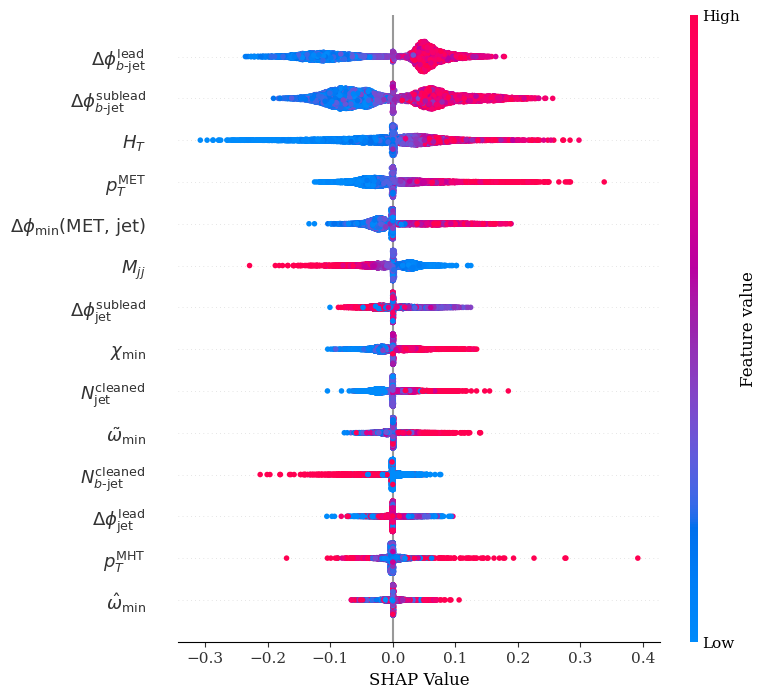

/tmp/ipykernel_3930827/394911088.py:39: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


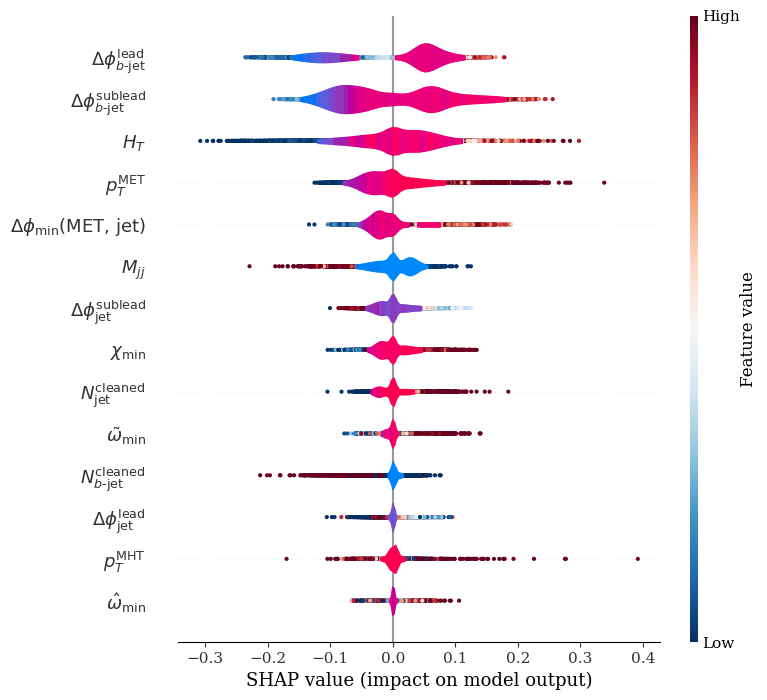

In [46]:
labels = [
    r"$M_{jj}$",
    r"$H_T$",
    r"$\Delta\phi_{\text{min}}(\text{MET, jet})$",
    r"$p_T^{\text{MET}}$",
    r"$p_T^{\text{MHT}}$",
    r"$\chi_{\text{min}}$",
    r"$\hat{\omega}_{\text{min}}$",
    r"$\tilde{\omega}_{\text{min}}$",
    r"$\Delta\phi^{\text{lead}}_{b\text{-jet}}$",
    r"$\Delta\phi^{\text{lead}}_{\text{jet}}$",
    r"$N_{b\text{-jet}}^{\text{cleaned}}$",
    r"$N_{\text{jet}}^{\text{cleaned}}$",
    r"$\Delta\phi^{\text{sublead}}_{b\text{-jet}}$",
    r"$\Delta\phi^{\text{sublead}}_{\text{jet}}$"
]


# For a beeswarm/dot plot (what you currently have):
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_array,
    X_explain,
    feature_names=labels,  # Use your LaTeX labels instead of features
    plot_type="dot",       # Explicitly set to dot/beeswarm
    show=False,
    color_bar=True,
    max_display=14         # Show all features
)
#plt.title("SHAP Feature Importance (Beeswarm Plot)")
plt.tight_layout()
plt.savefig('shap_beeswarm_custom.png', dpi=300)
plt.xlabel("SHAP Value", fontsize=12)  # Custom x-axis label

plt.show()

# For a violin plot (like in my custom function):
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_array,
    X_explain,
    feature_names=labels,  # Use your LaTeX labels
    plot_type="violin",    # Explicitly set to violin
    show=False,
    color_bar=True,
    cmap=plt.cm.RdBu_r,    # Red-Blue reversed colormap
    max_display=14         # Show all features
)
#plt.title("SHAP Feature Importance (Violin Plot)")
plt.tight_layout()
plt.savefig('shap_violin_custom.png', dpi=300)
plt.show()